# <center> TP n°2 - Transmission OFDM à N modulateurs/démodulateurs complexes</center>

<!-- Image dans le même répertoire ![emetteur N mod complexe](images/image_notebook.png) -->

<img src="https://lh3.googleusercontent.com/d/1lRRAjt4RNj0H38nlSAcgGJCLyddyy09G" align=center width="600"> 


La modulation OFDM "Orthogonal Frequency Division Multiplexing" est la plus utilisée aujourd'hui dans les systèmes avec des débits importants comme le Wifi, l'ADSL, VDSL, la 4G, 5G, TNT, CPL, .... Elle est dite large bande car la rapidité de modulation R du signal modulé est grande et donc la DSP du signal est large. 

L'intérêt principale de l'OFDM dans les systèmes de transmissions hertzien par rapport à une modulation mono-porteuse réside dans la simplification (diminution de la puissance de calcul nécessaire) de la réalisation des égaliseurs sur le récepteur. Ceci est possible car on passe d'une modulation avec grande une rapidité de modulation et donc un temps symbole faible à une multitude de modulation avec des rapidité de modulation faible et donc un temps symbole long de l'ordre des différences de temps de propagation entre la trajet direct et le trajet réfléchi le plus long.    

Vous aurez 2 TP psur l'OFDM. Le premier présentera les concepts théoriques d'une transmission OFDM réalisée à l'aide de N modulateurs / démodulateurs avec de passer à un second TP avec son implémentation pratique à iFFT. Dans les systèmes de transmission hertzienne, toutes les sous-porteuses utilisent la même modulation PSK ou QAM et c'est ce qu'on implémentera ici pour simplifier le code. Sur des systèmes comme l'ADSL, VDSL ou le CPL, chaque sous-porteuse peut utiliser une modulation différente en fonction du rapport signal qur bruit dans la sous-bande.

On ne pourra pas directement réutiliser la classe `Modem` définie dans le module R305 sur les transmissions numériques car elle n'est pas totalement adaptée au cas de l'OFDM. Cependant les fonctions de base définies dans cette classe (filtre de mise en forme `filtre_MF`,`upconversion`, `detection` ,`demapping`, ...) vont être réutilisées, parfois avec quelques modifications.

On a donc créé une nouvelle classe `Ofdm` dans le module `commNumv4` avec des méthodes statiques pour regrouper ces fonctions qui vont être utilisées ensembles mais qui ne dépendent pas de l'état d'un objet spécifique. Ces  méthodes statiques de classe peuvent être appelées sous la forme `Ofdm.methode` sans avoir besoin de créer une instance de la classe.

## Import des modules

In [7]:
from commNumv4 import Modem
from commNumv4 import Mesure
from commNumv4 import Source
from commNumv4 import Canal
from commNumv4 import Ofdm
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import importlib

## Ré-import d'une classe du module commNum en cas de modification

Si vous modifiez une classe du module commNum il faut la ré-importer. Par exemple si on a modifié la classe *Source*, il faudra relancer la cellule ci-dessous en commencant par ré-importer une autre classe par exemple *Mesure*, puis relancer un deuxième fois la cellule mais pour la classe *Source*. 

Pour être sûr que le ré-import s'est bien effectué, n'hesitez pas à mettre un print d'une chaîne de caractères différente à chaque ré-import dans votre classe.

In [8]:
import commNumv4;from commNumv4 import Ofdm
importlib.reload(commNumv4)

<module 'commNumv4' from 'c:\\Users\\energ\\OneDrive\\Documents\\BUT2\\RT4R02\\TP2\\commNumv4.py'>

La commande magique `%matplotlib inline` permet d'inserer le numéros de ligne dans les cellules de code.

In [4]:
%matplotlib inline

<div class="alert alert-block alert-success">
        
## I. Emetteur OFDM à N modulateurs complexes
    
</div>

L'architecture du modulateur OFDM à N=4 modulateurs complexes que vous devez réaliser avec les structures de données associées est illustré sur la figure ci-dessous :

<!-- Image dans le même répertoire ![emetteur N mod complexe](images/Emetteur_OFDM_K_v3.png) -->

<img src="https://lh3.googleusercontent.com/d/15kt6L15R3Bl-Q-61D1COQ2SdJJqPw4Uo" align=center> 

<div class="alert alert-block alert-info bilan">

### 1. Caractéristiques de la transmission OFDM

On veut faire une **transmission OFDM** avec les caractéristique suivantes :
- Rapidité de modulation `R` : **1000 symboles/s**. Il s'agit de la rapidité de modulation des symboles numériques OFDM edonc celle des symboles de modulation de chaque sous-porteuse  
- Nombre de sous-porteuses `nb_sp` : **4 sous-porteuses**  
- Type de modulation pour chaque sous-porteuse : **16 QAM**. Vous en déduirez le nombre de bits par symbole `bits_par_symb_sp` et le nombre de bits dans un symbole OFDM `bits_par_symb_ofdm`. La table de mapping est déjà donnée dans le bloc de code.  
- Facteur de `upsampling` du filtre de mise en forme rectangulaire : **100**. Vous en déduirez `fe` la fréquence d'échantillonnage et `te` la période d'échantillonnage  
- Fréquence `f0` de la première sous-porteuse : **3000Hz**.  
- Ecart `df` entre les sous-porteuses : sera choisi pour que les sous-porteuses soient orthogonales  
- Nombre de symboles OFDM transmis `nb_symb_ofdm` : 1000. Vous en déduirez le nombre de bits transmis `nb_bits`.  

</div>`

In [9]:
########## mapping table 16QAM #############
mapping_table = {
                    (0,0,0,0) : -3-3j,
                    (0,0,0,1) : -3-1j,
                    (0,0,1,0) : -3+3j,
                    (0,0,1,1) : -3+1j,
                    (0,1,0,0) : -1-3j,
                    (0,1,0,1) : -1-1j,
                    (0,1,1,0) : -1+3j,
                    (0,1,1,1) : -1+1j,
                    (1,0,0,0) :  3-3j,
                    (1,0,0,1) :  3-1j,
                    (1,0,1,0) :  3+3j,
                    (1,0,1,1) :  3+1j,
                    (1,1,0,0) :  1-3j,
                    (1,1,0,1) :  1-1j,
                    (1,1,1,0) :  1+3j,
                    (1,1,1,1) :  1+1j}

###############################################
#### Caractéristiques de la transmission #####
###############################################


# Paramètres OFDM
R = 1000  
nb_sp = 4  
modulation = '16QAM'
bits_par_symb_sp = np.log2(len(mapping_table)) 
bits_par_symb_ofdm = nb_sp * bits_par_symb_sp 
upsampling = 100  
fe = R * upsampling  
te = 1 / fe  
f0 = 3000  
df = R  
nb_symb_ofdm = 1000  
nb_bits = nb_symb_ofdm * bits_par_symb_ofdm  

print(f"bits_par_symb_sp = {bits_par_symb_sp}")
print(f"bits_par_symb_ofdm = {bits_par_symb_ofdm}")
print(f"fe = {fe} Hz, te = {te} s")
print(f"df = {df} Hz")
print(f"nb_bits = {nb_bits}")

bits_par_symb_sp = 4.0
bits_par_symb_ofdm = 16.0
fe = 100000 Hz, te = 1e-05 s
df = 1000 Hz
nb_bits = 16000.0


<div class="alert alert-block alert-info bilan">

### 2. Mise en forme des symboles numériques
    
A l'aide de la fonction `reshape`, réorganiser les bits pour avoir une matrice nommée `symbs_num_para` de dimension (nombre de symbole OFDM, Nombre de sous-porteuses, Nombre de bits par sous-porteuse). Afficher cette matrice.  

    
Remarque : vous aurez une suites de symbole numériques OFDM avec les symboles associés à chaque sous-porteuse en parallèle c'est à dire sur des lignes différentes. 

</div>

In [18]:
bits = np.random.randint(0, 2, nb_bits)

# Mise en forme des symboles numériques OFDM
symbs_num_para = bits.reshape((nb_symb_ofdm, nb_sp, int(bits_par_symb_sp)))
print(bits_par_symb_sp)
print(symbs_num_para)

4.0
[[[1 0 1 1]
  [1 1 0 0]
  [0 1 1 0]
  [1 1 0 0]]

 [[0 0 0 0]
  [0 1 0 0]
  [1 1 0 0]
  [0 1 0 0]]

 [[0 0 1 0]
  [1 0 0 0]
  [0 0 1 0]
  [0 1 0 1]]

 ...

 [[1 1 1 1]
  [0 0 0 0]
  [0 0 0 1]
  [0 0 0 1]]

 [[0 0 1 0]
  [0 0 0 0]
  [1 0 1 1]
  [1 1 1 0]]

 [[1 1 0 1]
  [0 1 1 1]
  [1 0 0 1]
  [1 0 1 0]]]


<div class="alert alert-block alert-info bilan">

### 3. Mapping OFDM

On souhaite ici faire le mapping des symboles numériques vers les symboles de modulation complexes associés à la modulation 16QAM et obtenir une matrice nommée `symbs_mod_para` avec l'ensemble des symboles de modulation d'une sous-porteuse sur une même ligne. On aura donc au final un matrice (4 (sous-porteuses), 1000 symboles) correspondant aux symboles de modulations des différentes sous-porteuses en parallèle c'est à dire sur des lignes différentes.

<br>

A l'aide d'une boucle d'indice i sur le nombre de symbole OFDM, vous pouvez effectuer le mapping avec le code suivant :  

`symbs_mod_para[i,] = np.array([mapping_table[tuple(symb)] for symb in symbs_num_para[i,:,:]])`

<br>
    
Vous obtiendrez les symboles numériques des différentes sous-porteuses en parallèle mais sur des colonnes différentes. A l'aide de la méthode `transpose` vous pourrez alors obtenir la matrice souhaitée.  
    
    
Remarque : on rappelle que la transposée d'une matrice inverse ses lignes et ses colonnes. Il faut fra initialiser la matrice `symbs_mod_para=np.zeros((nb_symb_ofdm, nb_sp), dtype = complex)`.
    
Vous vérifierez que les 3 premiers symboles de modulation de la première sous porteuse sont biens les bons.  

</div>

In [19]:
# Initialisation de la matrice pour les symboles modulés
symbs_mod_para = np.zeros((nb_symb_ofdm, nb_sp), dtype=complex)
for i in range(nb_symb_ofdm):
    symbs_mod_para[i, :] = np.array([mapping_table[tuple(symb)] for symb in symbs_num_para[i, :, :]])
# Transposer pour avoir (nb_sp, nb_symb_ofdm)
symbs_mod_para = symbs_mod_para.T
# Vérification des 3 premiers symboles de modulation de la première sous-porteuse
print(symbs_mod_para[0, :3])

[ 3.+1.j -3.-3.j -3.+3.j]


<div class="alert alert-block alert-warning">

#### VERIFICATIONS
    
Vérifier que les 2 premiers symboles de la première sous-porteuse correspondent bien au 2 symbole numériques associés.
    
........................
<br><br>


</div>

<div class="alert alert-block alert-info bilan">

### 4. Filtre de mise en forme rectangulaire

A l'aide de la fonction `np.repeat`, réaliser le filtre de mise en forme rectangulaire sur la suite de symbole de modulation. 
    
Remarque : Vous utiliserez l'option `axis = 1` pour effectuer l'opération de répétition sur les éléments d'une ligne c'est à dire d'une sous-porteuse.
<br>    
Vous vérifierez les dimensions de la matrice associée.

</div>

In [20]:
# Filtre de mise en forme rectangulaire par répétition
symbs_mod_rect = np.repeat(symbs_mod_para, upsampling, axis=1)
print('Dimensions de la matrice après mise en forme rectangulaire :', symbs_mod_rect.shape)

Dimensions de la matrice après mise en forme rectangulaire : (4, 100000)


<div class="alert alert-block alert-warning">

#### VERIFICATIONS
    
Vérifier la taille de la matrice : 

........................
<br><br>

</div>

<div class="alert alert-block alert-info bilan">

### 5. Upconversion et génération du signal OFDM

La fonction `exp_comp` définie dans comme méthode statique de la classe modem permet de définir une exponentielle complexe à la fréquence `fp`et comprenant  N valeurs avec un période d'échantillonnage `te`.
    
    
    def exp_comp(fp,te,N):  
        t=np.arange(0,N*te,te)  
        reel=np.cos(2*np.pi*fp*t)  
        im=np.sin(2*np.pi*fp*t)  
        exp=reel+im*1j  
        return(exp)   

La fonction `exp_para` de la classe `Ofdm` permet de définir `nb_sp` exponentionnelles complexes en parallèle c'est à dire sur des lignes différentes avec une fréquence de `f0+i.df` pour la ligne $i$, f0 correspondant à la fréquence de la première exponentielle, et df, l'écart en fréquence avec les exponentielles suivantes. Cette matrice pourra être multipliée par la matrice avec l'enveloppe complexe des différentes sous-porteuses, une sous-porteuse par ligne pour obtenir le signal analytique de chaque sous-porteuse.
    
    def exp_para(np_sp, f0, df,te,N):  
        exp_para = exp_comp(f0,te,N)     
        for i in range(1,nb_sp): 
            exp = exp_comp(f0+i*df,te,N)  
            exp_para = np.vstack((exp_para,exp)) 
        return(exp_para)     

Créer le signal OFDM avec les étapes suivantes :
1. Créer la matrice avec les signaux analytiques de chaque sous-porteuse en parallèle
2. Créer le signal analytique OFDM en sommant `np.sum`, sur une même colonne (axis = 0), les échantillons associés aux signaux analytiques des différentes sous-orteuses
3. Prendre la partie réelle sur signal analytique OFDM pour obtenir le signal OFDM. 
 
</div>

In [21]:
# Génération des exponentielles complexes pour chaque sous-porteuse
N = symbs_mod_rect.shape[1]
exp_para = Ofdm.exp_para(nb_sp, f0, df, te, N)

# Multiplication pour obtenir les signaux analytiques de chaque sous-porteuse
signaux_analytique = symbs_mod_rect * exp_para

# Signal analytique OFDM (somme des sous-porteuses)
signal_analytique_ofdm = np.sum(signaux_analytique, axis=0)

# Signal OFDM réel
signal_ofdm = np.real(signal_analytique_ofdm)

<div class="alert alert-block alert-info bilan">

### 6. Affichage des signaux modulés des sous-porteuses, du signal OFDM et de leur DSP

Vous afficherez (print) les valeurs des 5 premiers symboles de modulation de chaque sous-porteuse et l'allure temporelle (plot en fonction du numéro d'échantillon) des signaux modulés associés à chaque sous-porteuse sur 5 temps symboles plus le signal OFDM.
<br>   
Vous vérifierez pour chaque sous-porteuse que la forme d'onde de 0 à upsampling correspond bien au premier symbole de modulation.
</div>

Les 5 premiers symboles de la sous-porteuse 1 sont : 
[ 3.+1.j -3.-3.j -3.+3.j  3.-1.j -1.+3.j]

Les 5 premiers symboles de la sous-porteuse 2 sont : 
[ 1.-3.j -1.-3.j  3.-3.j -3.-1.j -3.-3.j]

Les 5 premiers symboles de la sous-porteuse 3 sont : 
[-1.+3.j  1.-3.j -3.+3.j -1.-1.j -1.-3.j]

Les 5 premiers symboles de la sous-porteuse 4 sont : 
[ 1.-3.j -1.-3.j -1.-1.j  3.-3.j -1.+1.j]



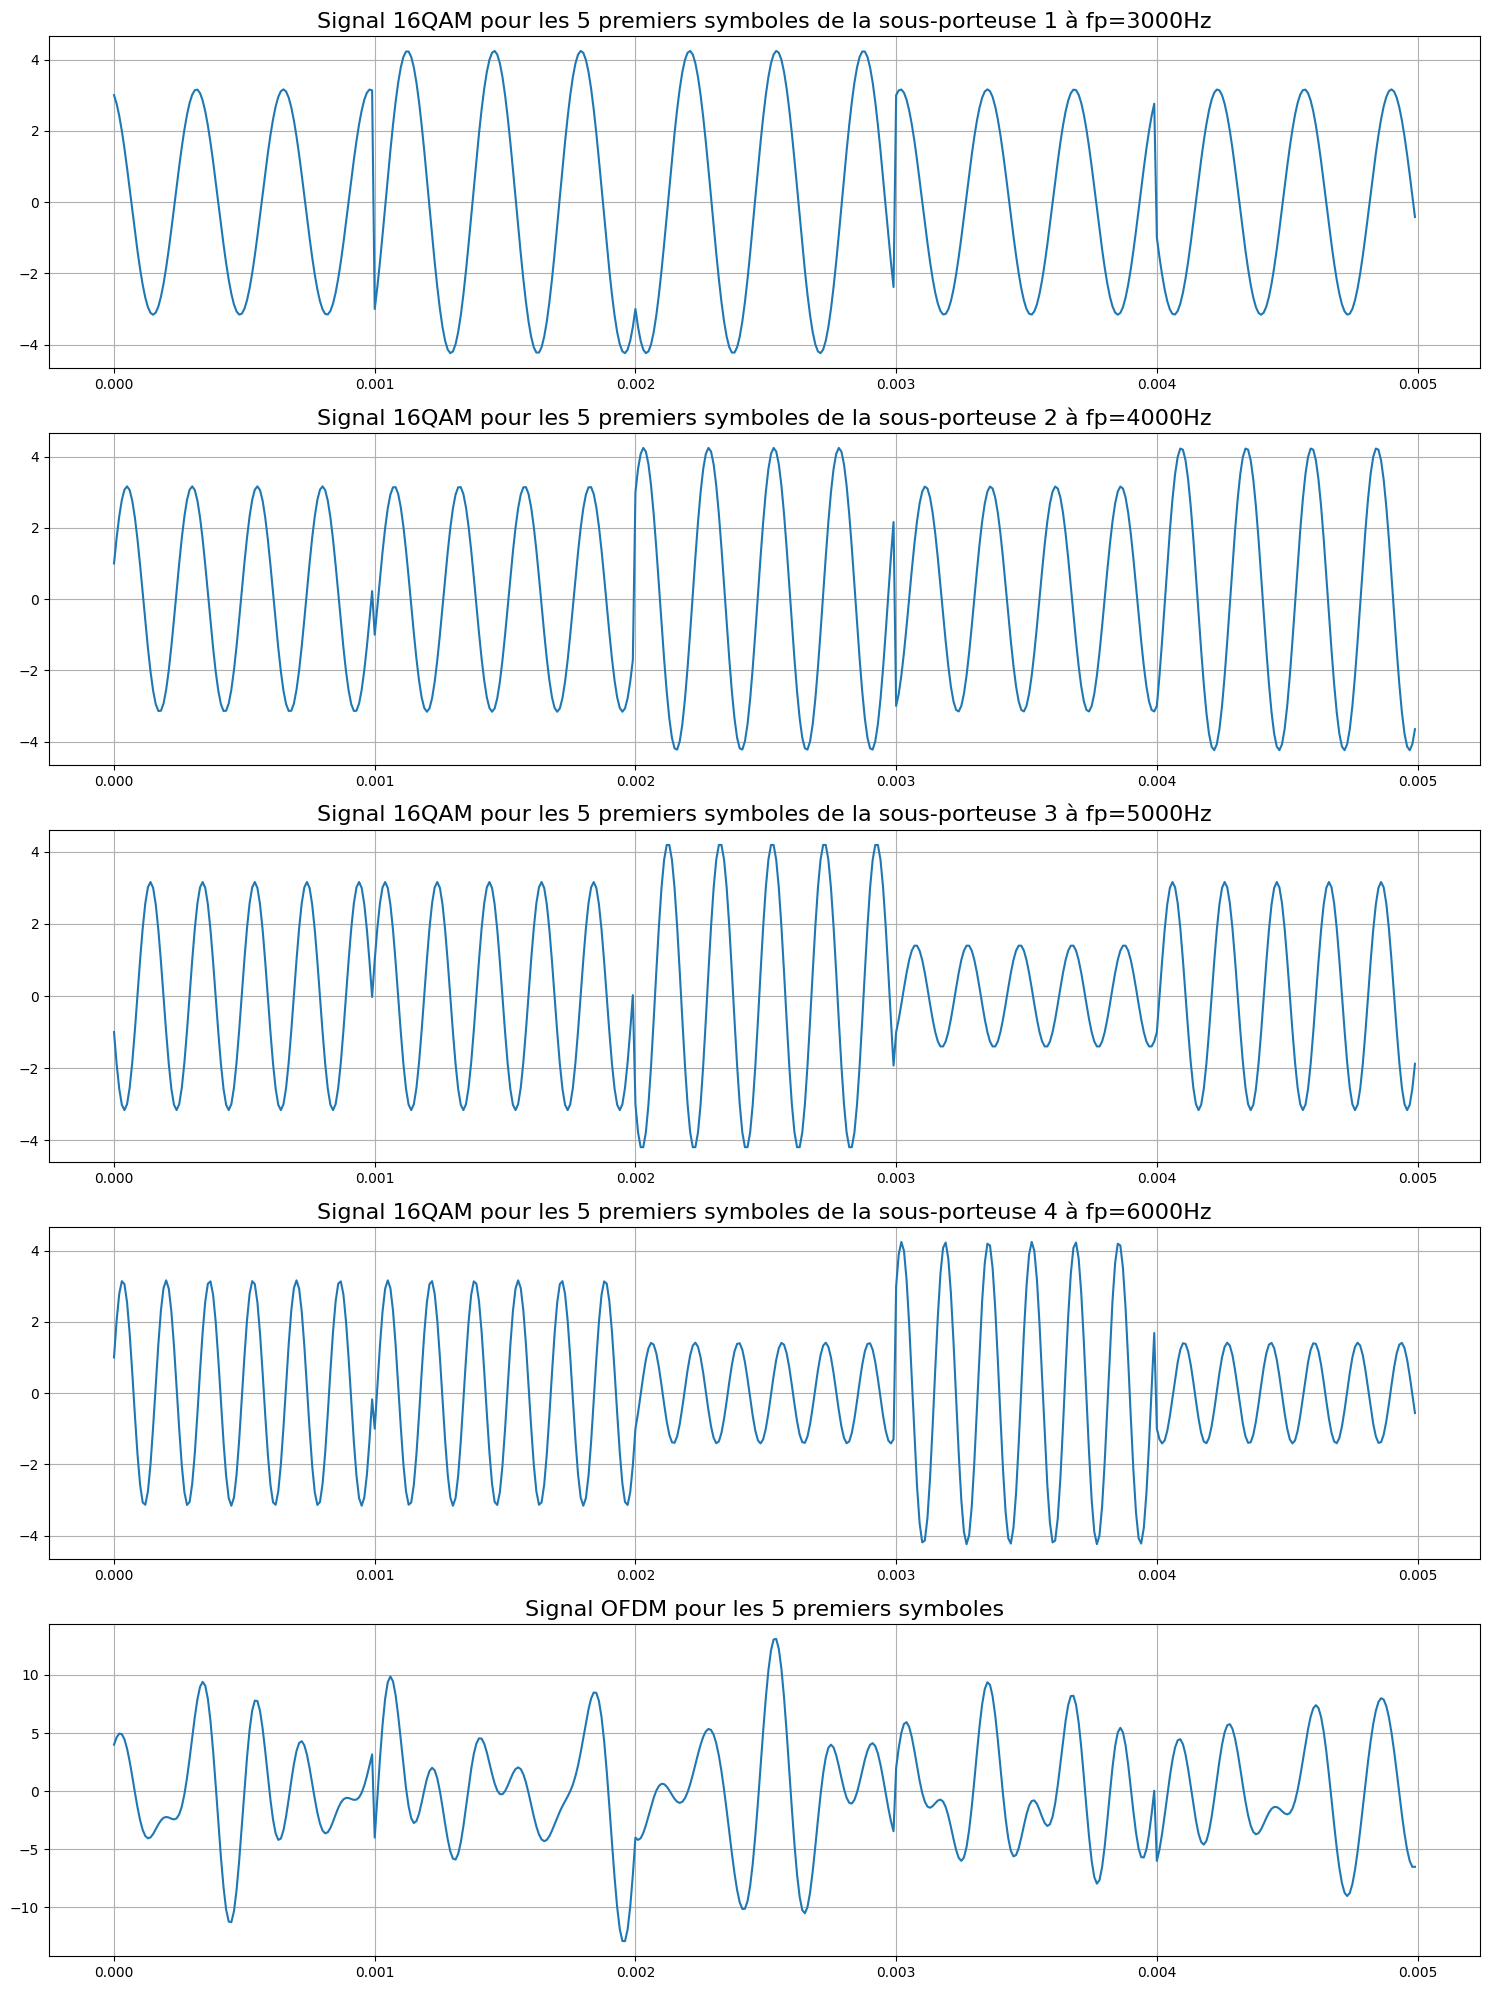

In [22]:
# Affichage des 5 premiers symboles de modulation de chaque sous-porteuse
for k in range(nb_sp):
    print(f'Les 5 premiers symboles de la sous-porteuse {k+1} sont : \n{symbs_mod_para[k, :5]}\n')

# Affichage temporel des signaux modulés (5 symboles, soit 5*upsampling échantillons)
figure, ax = plt.subplots(5, 1, figsize=(15, 20))
t = np.arange(5 * upsampling) / fe
for k in range(nb_sp):
    ax[k].plot(t, np.real(signaux_analytique[k, :5*upsampling]))
    ax[k].set_title(f"Signal 16QAM pour les 5 premiers symboles de la sous-porteuse {k+1} à fp={f0 + k*df}Hz", fontsize=16)
    ax[k].grid()
ax[4].plot(t, signal_ofdm[:5*upsampling])
ax[4].set_title("Signal OFDM pour les 5 premiers symboles", fontsize=16)
ax[4].grid()
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning">

#### VERIFICATIONS
    
Vérifier pour chaque sous-porteuse que la première forme d'onde émise sur un temps symbole correspond bien au premier symbole de modulation.
      
........................
<br><br>
 
</div>

<div class="alert alert-block alert-info bilan">

**Afficher à l'aide de la classe Mesure, la DSP moyenne des sous-porteuses et du signal OFDM avec la méthode** `f, DSP = dsp_moy(signal, fe, nombre d'échantillons de la FFT)`.
    
On prendra un 1 FFT sur 100 symboles OFDM (soit 10000 échantillons puisqu'on a un facteur de upsampling de 100), et on aura donc une DSP moyenne sur 10 FFT puisqu'on a généré 1000 symboles OFDM. ON affichera la DSP de 0 à 10KHz.
 
</div>

In [23]:
nsymb_fft = 100
nech_fft = nsymb_fft * upsampling
# DSP moyenne pour chaque sous-porteuse (partie réelle du signal analytique de chaque sous-porteuse)
f, DSP0 = Mesure.dsp_moy(np.real(signaux_analytique[0]), fe, nech_fft)
f, DSP1 = Mesure.dsp_moy(np.real(signaux_analytique[1]), fe, nech_fft)
f, DSP2 = Mesure.dsp_moy(np.real(signaux_analytique[2]), fe, nech_fft)
f, DSP3 = Mesure.dsp_moy(np.real(signaux_analytique[3]), fe, nech_fft)
# DSP moyenne du signal OFDM
f, DSPOFDM = Mesure.dsp_moy(signal_ofdm, fe, nech_fft)

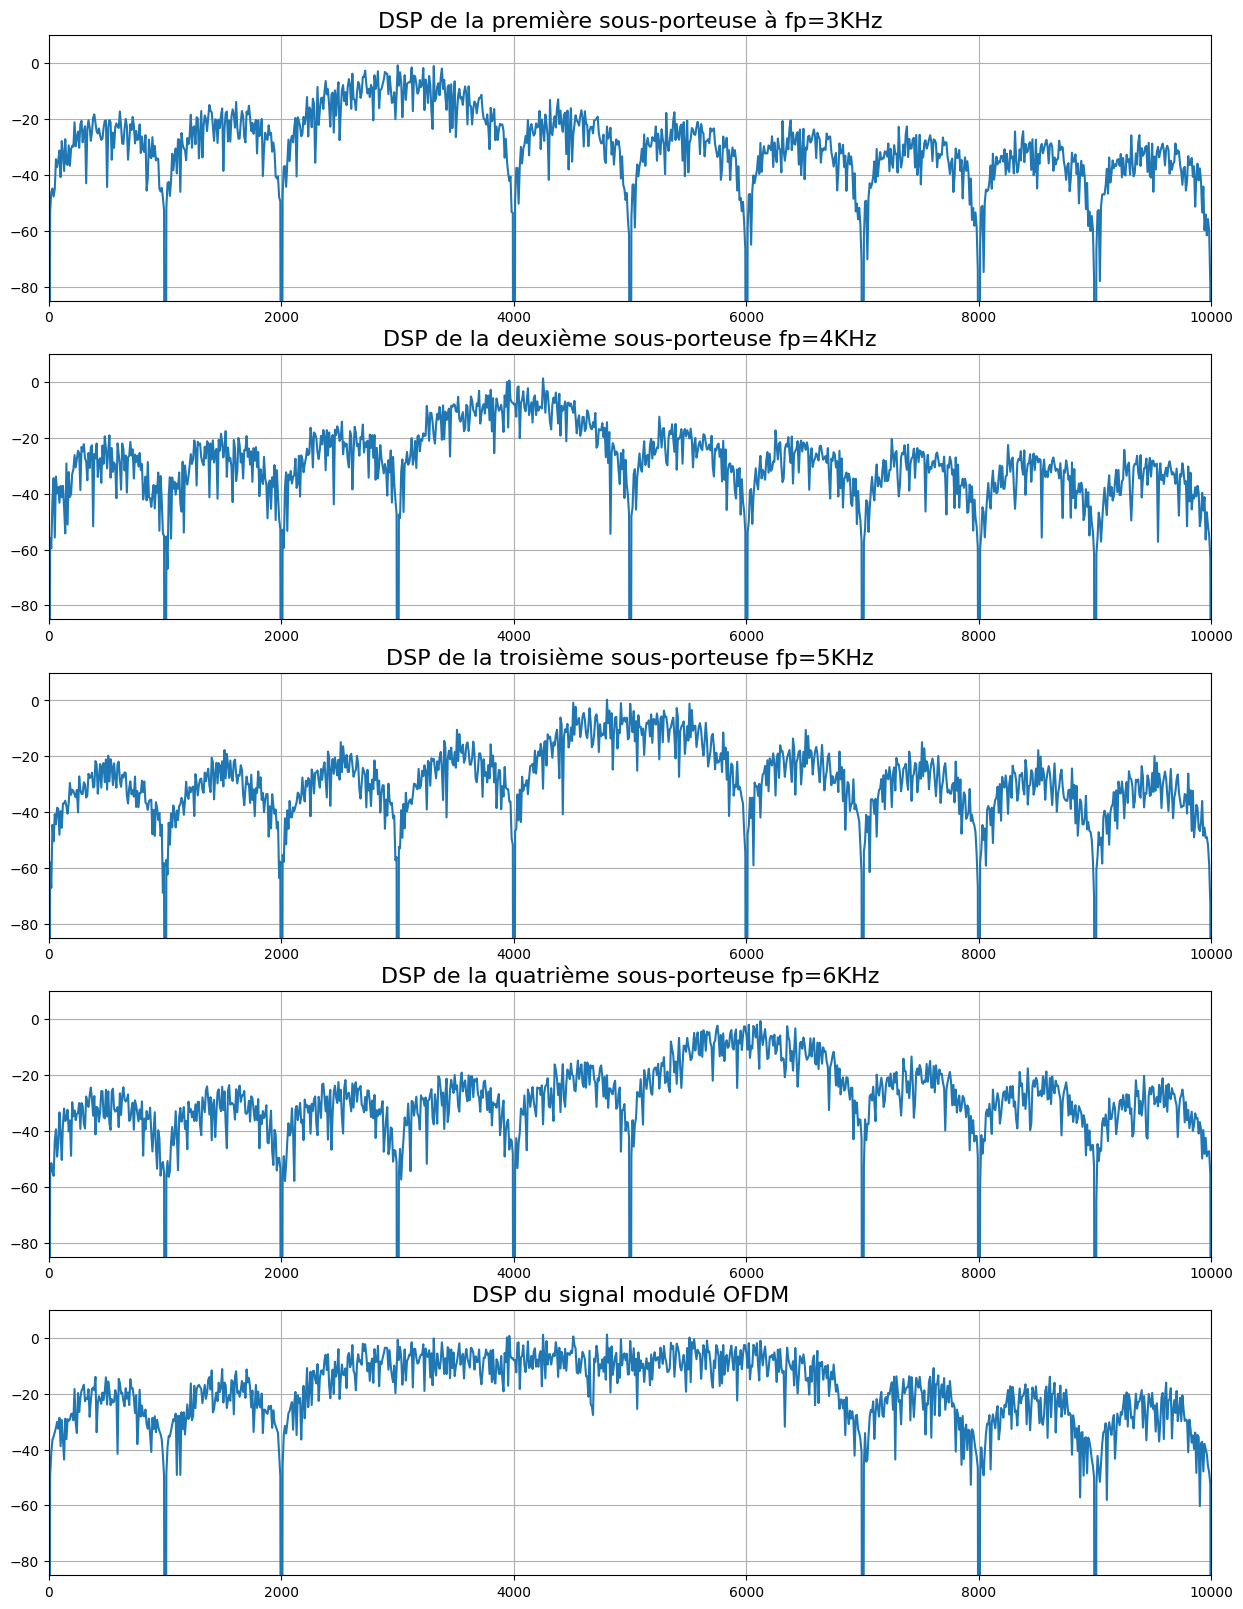

<Figure size 640x480 with 0 Axes>

In [24]:
fig, ax = plt.subplots(5, 1, figsize = (15, 20))
ax[0].plot(f,DSP0)
ax[0].grid()
ax[0].set_xlim([0, 10e3])
ax[0].set_ylim([-85, 10])
ax[0].set_title("DSP de la première sous-porteuse à fp=3KHz", fontsize=16)
ax[1].plot(f,DSP1)
ax[1].set_xlim([0, 10e3])
ax[1].set_ylim([-85, 10])
ax[1].grid()
ax[1].set_title("DSP de la deuxième sous-porteuse fp=4KHz", fontsize=16)
ax[2].plot(f,DSP2)
ax[2].set_xlim([0, 10e3])
ax[2].set_ylim([-85, 10])
ax[2].grid()
ax[2].set_title("DSP de la troisième sous-porteuse fp=5KHz", fontsize=16)
ax[3].plot(f,DSP3)
ax[3].set_xlim([0, 10e3])
ax[3].set_ylim([-85, 10])
ax[3].grid()
ax[3].set_title("DSP de la quatrième sous-porteuse fp=6KHz", fontsize=16)
ax[4].plot(f,DSPOFDM)
ax[4].set_xlim([0, 10e3])
ax[4].set_ylim([-85, 10])
ax[4].grid()
ax[4].set_title("DSP du signal modulé OFDM", fontsize=16)
plt.show()
plt.tight_layout()

<div class="alert alert-block alert-warning">

#### VERIFICATIONS
    
Vérifier pour chaque sous-porteuse la fréquence porteuse et la largeur de bande du lobe principal.
      
........................
<br><br>
 
</div>

<div class="alert alert-block alert-success">
        
## II. Canal AWGN
    
</div>

<div class="alert alert-block alert-info bilan">

### Canal AWGN

A l'aide de la classe Canal, ajouter un bruit blanc gaussien au signal OFDM avec une moyenne nulle et une variance de 0.4.
  
</div>

In [26]:
# Ajout d'un bruit blanc gaussien au signal OFDM
variance_bruit = 0.4
signal_ofdm_bruite = Canal.awgn(signal_ofdm, 0, variance_bruit)

<div class="alert alert-block alert-success">
        
## III. Récepteur OFDM à N démodulateurs complexes à corrélateurs
    
</div>

<div class="alert alert-block alert-info bilan">

### 1. Démodulation d'une sous-porteuse avec corrélateur, orthogonalité

L'architecture du récepteur OFDM à N filtres adaptés / corrélateurs est illustré ci-dessous :  
    
<!-- Image dans le même répertoire ![emetteur N mod complexe](images/Recepteur_OFDM_N.png) -->

<img src="https://lh3.googleusercontent.com/d/1YY7Rt620nrAU7LmmoReWJ_bn8bzzGGCP" align=center>

<br>
    
On souhaite dans un premier temps, à titre pédagogique, démoduler seulement la première sous-porteuse avec le corrélateur pour vérifier que les autres sous-porteuses sont orthogonales et n'interfèrent donc pas dans la démodulation de cette sous-porteuse.  
    
<br>  
    
Appliquer le corrélateur sur le signal OFDM non bruité pour la fréquence de la première sous-porteuse (on  utilisera la méthode `exp_comp` pour la multiplication par une exponentielle complexe et `moy_glissante` pour la somme normalisée sur les upsampling echantillons par symbole), le downsampling, la détection par calcul de distance et le démapping. 
    
<br> 
Vérifier que vous obtenez bien les mêmes 5 premiers symboles et 20 premiers bits que ceux transmis sur la première sous-porteuse. Vous afficherez (plot) de plus le signal avant et après downsampling sur 10 symboles.

</div>

Les 5 premiers symboles émis pour la première sous-porteuse sont :
[ 3.+1.j -3.-3.j -3.+3.j  3.-1.j -1.+3.j]
Les 5 premiers symboles reçus pour la première sous-porteuse sont :
[ 1.+1.j -1.-1.j -1.+1.j  1.-1.j -1.+1.j]

Les 20 premiers bits émis pour la première sous-porteuse sont :
[1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0]
Les 20 premiers bits reçus pour la première sous-porteuse sont :
[1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1]


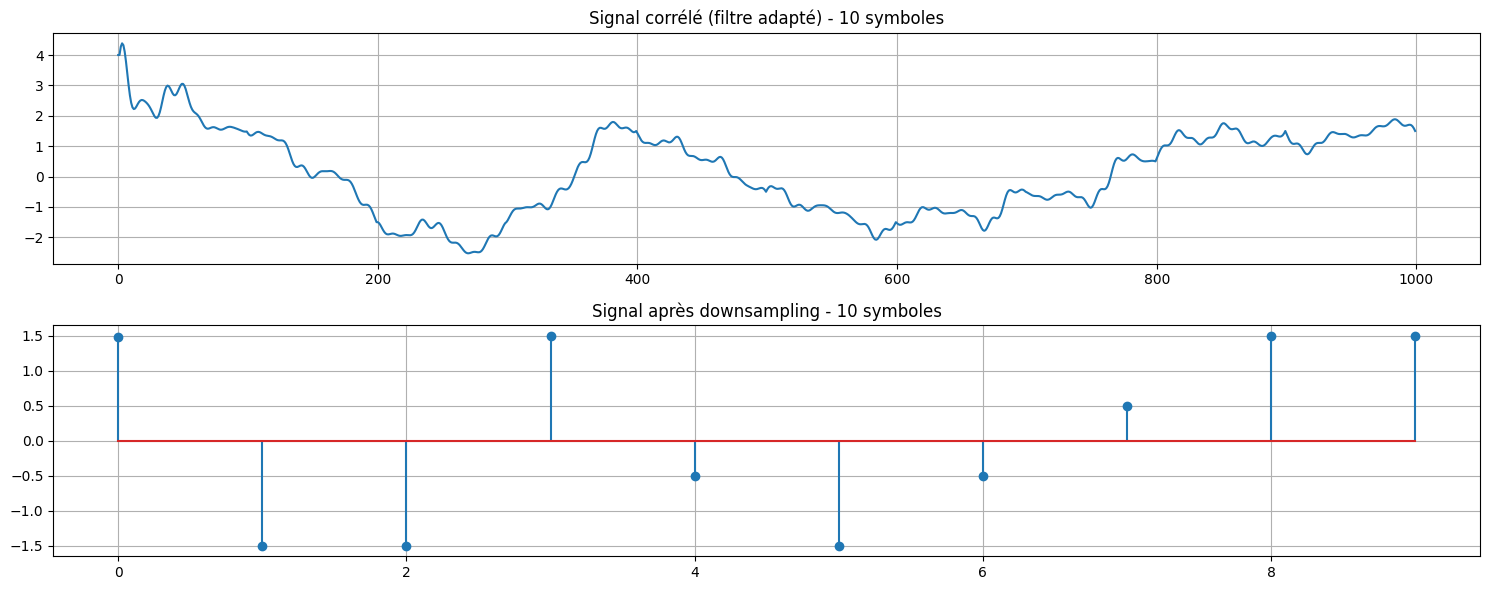

In [29]:
# Corrélateur pour la première sous-porteuse (fp = f0)
exp_corr = Ofdm.exp_comp(f0, te, len(signal_ofdm))
signal_corr = signal_ofdm * np.conj(exp_corr)

# Filtre adapté (moyenne glissante sur upsampling échantillons)
signal_corr_mf = Ofdm.moy_glissante(signal_corr, upsampling)

# Downsampling (échantillonnage à chaque symbole)
signal_corr_ds = signal_corr_mf[upsampling-1::upsampling]

# Détection (décision sur la constellation 16QAM)
mapping_points = np.array(list(mapping_table.values()))
symbs_rx = np.zeros(len(signal_corr_ds), dtype=complex)
for n, val in enumerate(signal_corr_ds):
    distances = np.abs(val - mapping_points)
    symbs_rx[n] = mapping_points[np.argmin(distances)]

# Démapping (conversion symboles -> bits)
demap_dict = {v: k for k, v in mapping_table.items()}
bits_rx = np.array([bit for symb in symbs_rx for bit in demap_dict[symb]])

# Affichage des résultats
print(f'Les 5 premiers symboles émis pour la première sous-porteuse sont :\n{symbs_mod_para[0, :5]}')
print(f'Les 5 premiers symboles reçus pour la première sous-porteuse sont :\n{symbs_rx[:5]}\n')
print(f'Les 20 premiers bits émis pour la première sous-porteuse sont :\n{symbs_num_para[:5,0,:].flatten()}')
print(f'Les 20 premiers bits reçus pour la première sous-porteuse sont :\n{bits_rx[:20]}')

# Affichage du signal avant et après downsampling sur 10 symboles
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(np.real(signal_corr_mf[:10*upsampling]))
plt.title('Signal corrélé (filtre adapté) - 10 symboles')
plt.grid()
plt.subplot(2,1,2)
plt.stem(np.real(signal_corr_ds[:10]))
plt.title('Signal après downsampling - 10 symboles')
plt.grid()
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info bilan">

### 2. Récepteur OFDM à N (=4) récepteurs à filtre adapté
    
Ecrire une boucle sur le nombre de sous-porteuses permettant de récupérer une matrice nommée `symbs_mod_para` avec les symboles de modulation reçus, et une nommée `bits_rcv_para` avec les bits reçus des différentes sous-porteuses en parallèle (sur chaque ligne) à partir du signal OFDM bruité. 

</div>

In [30]:
# Récepteur OFDM à N (=4) récepteurs à filtre adapté
symbs_mod_rcv_para = np.zeros((nb_sp, nb_symb_ofdm), dtype=complex)
bits_rcv_para = np.zeros((nb_sp, int(nb_symb_ofdm * bits_par_symb_sp)), dtype=int)
for k in range(nb_sp):
    # Corrélation avec la k-ième sous-porteuse
    exp_corr = Ofdm.exp_comp(f0 + k*df, te, len(signal_ofdm_bruite))
    signal_corr = signal_ofdm_bruite * np.conj(exp_corr)
    # Filtre adapté
    signal_corr_mf = Ofdm.moy_glissante(signal_corr, upsampling)
    # Downsampling
    signal_corr_ds = signal_corr_mf[upsampling-1::upsampling]
    # Détection
    mapping_points = np.array(list(mapping_table.values()))
    symbs_rx = np.zeros(len(signal_corr_ds), dtype=complex)
    for n, val in enumerate(signal_corr_ds):
        distances = np.abs(val - mapping_points)
        symbs_rx[n] = mapping_points[np.argmin(distances)]
    symbs_mod_rcv_para[k, :] = symbs_rx[:nb_symb_ofdm]
    # Démapping
    demap_dict = {v: k for k, v in mapping_table.items()}
    bits_rx = np.array([bit for symb in symbs_rx[:nb_symb_ofdm] for bit in demap_dict[symb]])
    bits_rcv_para[k, :] = bits_rx[:int(nb_symb_ofdm * bits_par_symb_sp)]

<div class="alert alert-block alert-info bilan">

Afficher le diagramme de constellation des symboles reçus pour chaque sous-porteuse.

</div>

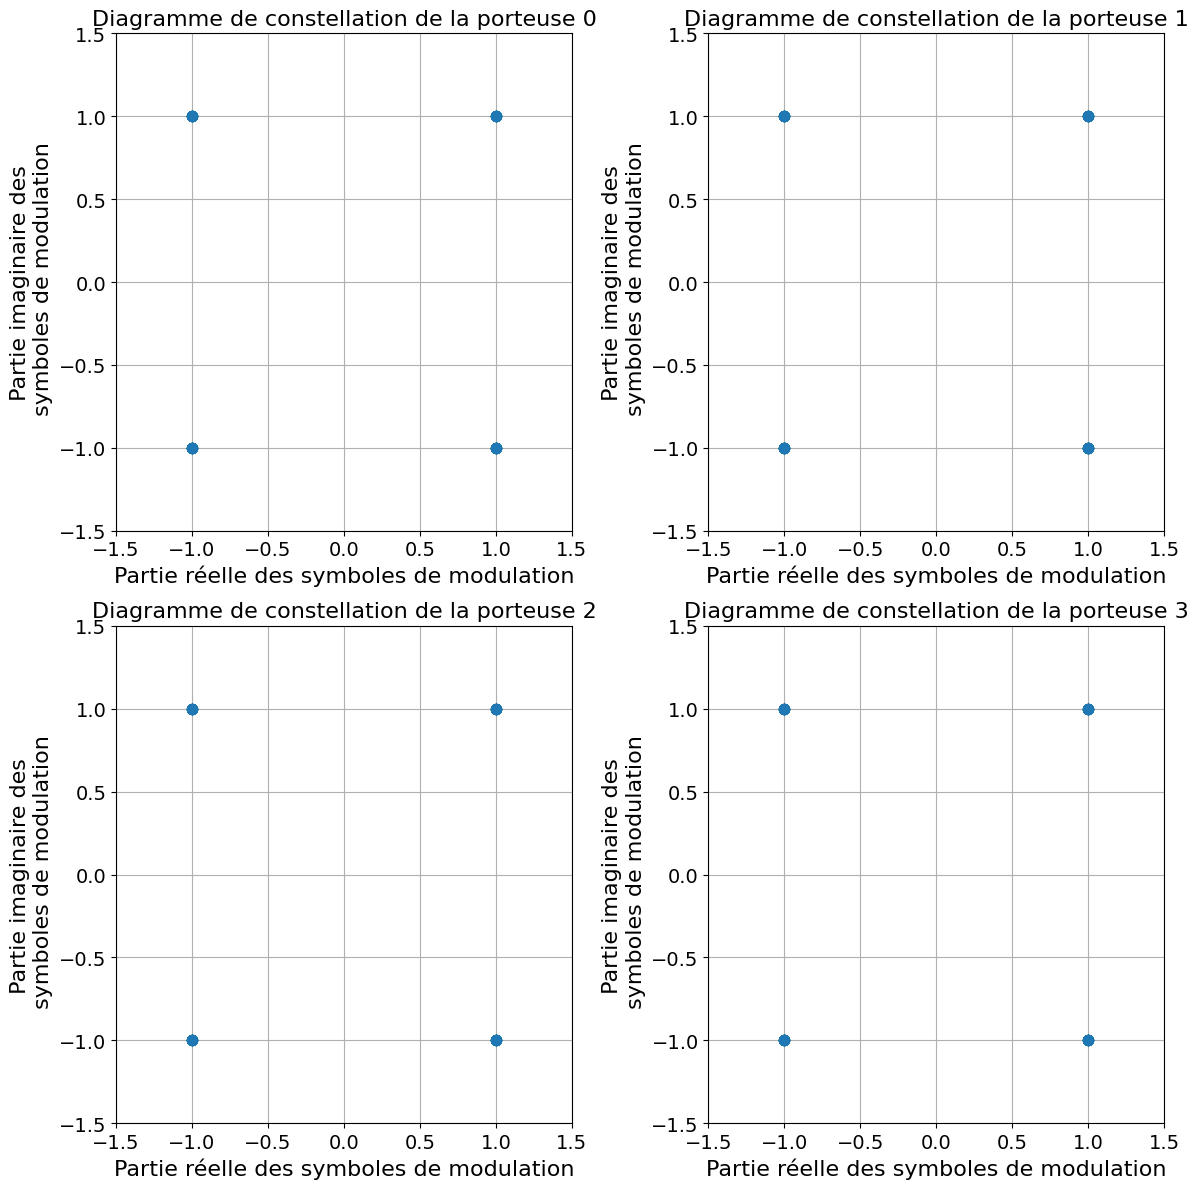

In [31]:
fig, ax = plt.subplots(2,2, figsize = (12, 12))
ligne =0
colonne = 0
for i in range(nb_sp):
    ax[ligne,colonne].plot(np.real(symbs_mod_para[i,]), np.imag(symbs_mod_para[i,]), 'o', mew=2)
    ax[ligne,colonne].grid()
    ax[ligne,colonne].set_ylabel(' Partie imaginaire des \n symboles de modulation', fontsize=16)
    ax[ligne,colonne].set_xlabel('Partie réelle des symboles de modulation', fontsize=16)
    ax[ligne,colonne].set_title('Diagramme de constellation de la porteuse '+str(i), fontsize=16)
    ax[ligne,colonne].xaxis.set_tick_params(labelsize=14)
    ax[ligne,colonne].yaxis.set_tick_params(labelsize=14)
    ax[ligne,colonne].set_xlim([-1.5,1.5])
    ax[ligne,colonne].set_ylim([-1.5,1.5])
    colonne+=1
    if i == 1 : 
        ligne = 1
        colonne = 0
    
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info bilan">

### 3. Conversion parallèle / série

La dernière étapes est la conversion parallèle série ce qui dans le cas de notre code, revient à passer des bits transportés par chaque sous-porteuse sur chaque ligne, à un vecteur de bits. 
   
La méthode `PS` de la classe `Ofdm` permet d'effectuer cette conversion parallèle-série. Le code est donné comme il n'apporte pas spécifiquement d'intérêt pour une meilleur compréhension de l'OFDM. 
 
    def PS(bits_rcv_para, nb_sp, nb_symb_ofdm, bits_par_symb_sp):   
        bits_rcv = np.empty((nb_symb_ofdm*nb_sp, bits_par_symb_sp),dtype=int)
        for i in range(nb_symb_ofdm):
            for j in range(nb_sp):
                bits_rcv[i*nb_sp+j,] = bits_rcv_para[j,i*bits_par_symb_sp:(i+1)*bits_par_symb_sp]
        return(bits_rcv.ravel())
    
<br>
Vous pouvez donc directement lancer la cellule ci-dessous et vérifier que vous obtenez bien les mêmes premiers 20 bits que ceux émis.

</div>

In [33]:
# Conversion parallèle / série
bits_rcv = Ofdm.PS(bits_rcv_para, nb_sp, nb_symb_ofdm, int(bits_par_symb_sp))
print('20 premiers bits émis :', bits[:20])
print('20 premiers bits reçus :', bits_rcv[:20])
print('Taux erreur binaire :', np.sum(bits != bits_rcv) / len(bits))

20 premiers bits émis : [1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0]
20 premiers bits reçus : [1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1]
Taux erreur binaire : 0.2525625


<div class="alert alert-block alert-info bilan">

### 4. Impact sur le diagramme de constellation d'un défaut d'orthogonalité

1. Regrouper l'ensemble du code pour générer le signal OFDM et le démoduler dans une même cellule (sans print ou plot). La variance du bruit dans le canal sera null pour visualiser seulement l'impact d'un défaut d'orthogonalité.  
<br>    
    
2. Modifier le code pour avoir des sous-porteuses espacées de df1 en émission et réception avec $df1 = 1.05*R$ puis $df1 = 1.1*R$. Vous visualiserez le diagramme de constellation des sous-porteuses.  
<br>
    
3. Vous concluerez sur l'impact d'un défaut d'orthogonalité et sur l'intérêt du diagramme de constellation pour caractériser les modulations.
    
</div>

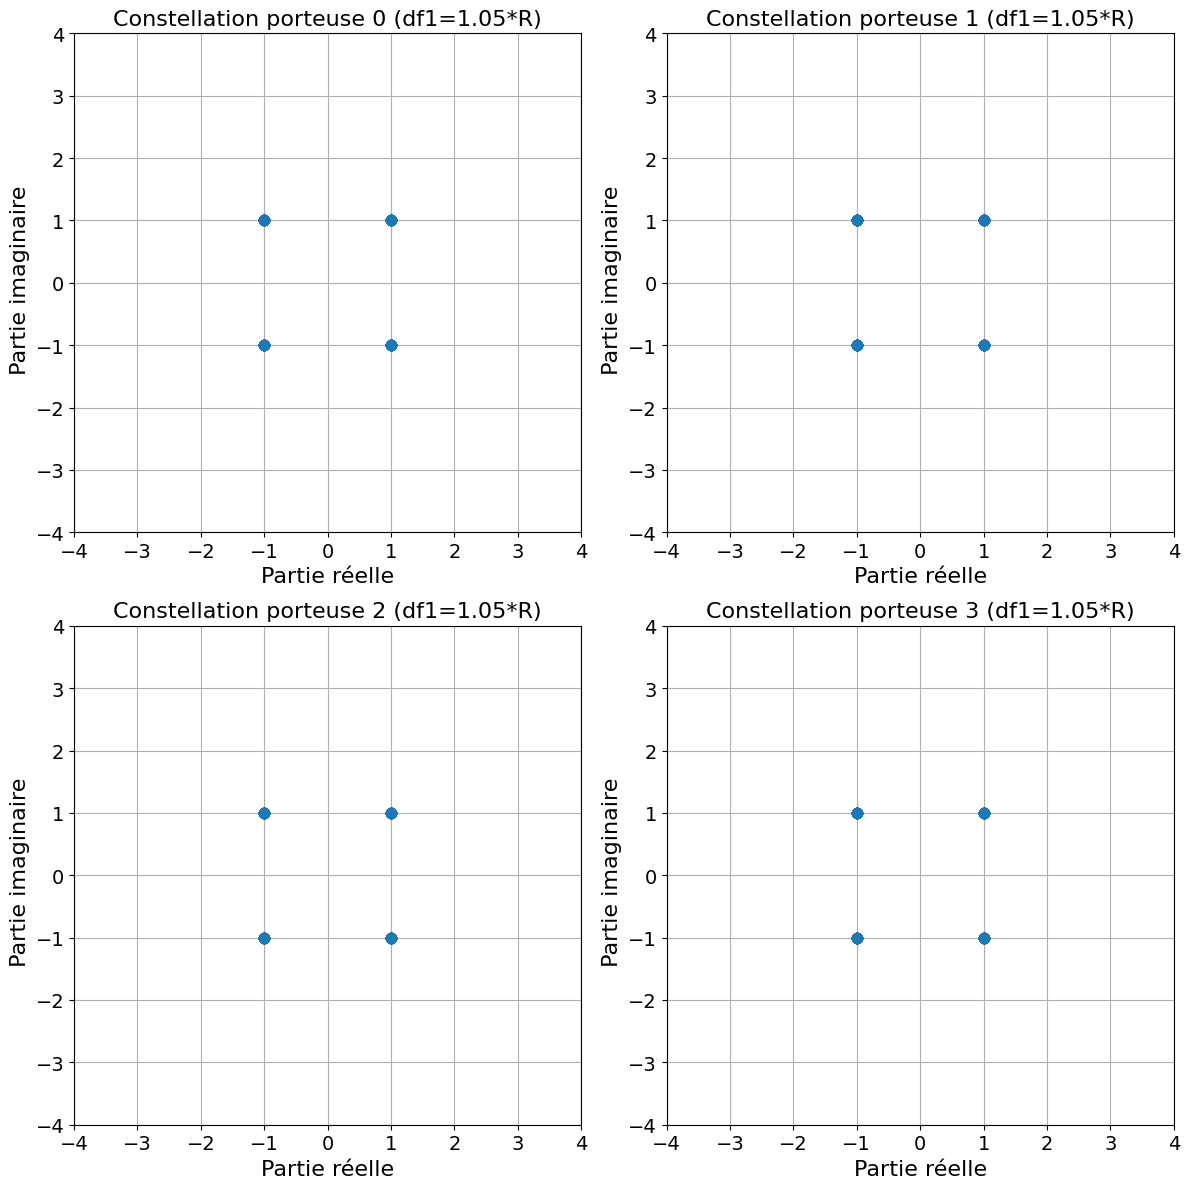

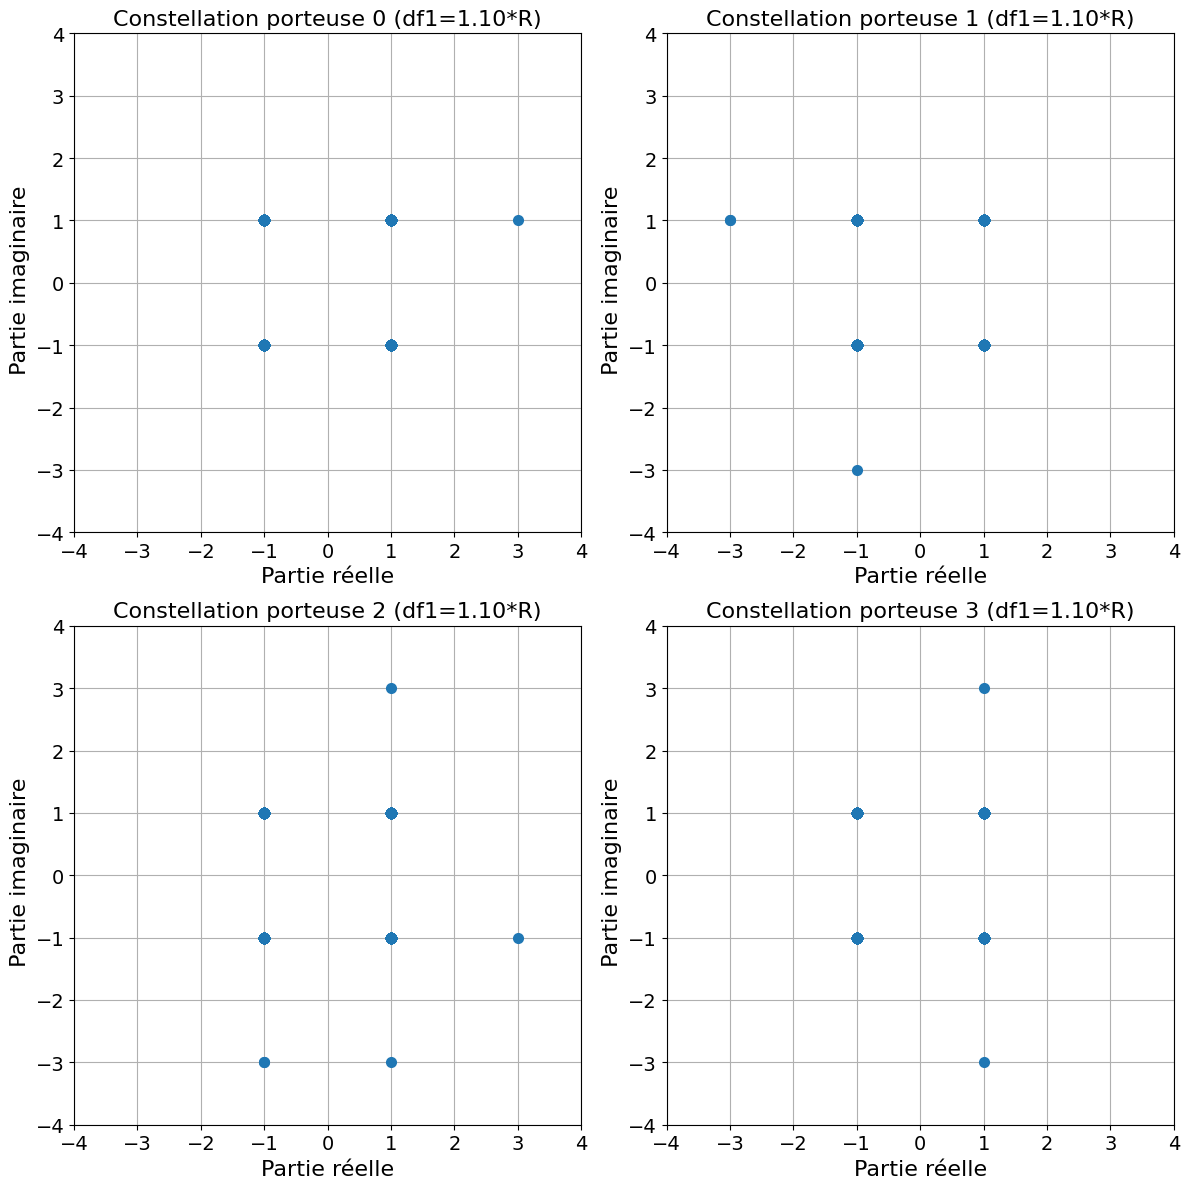

In [34]:
# Simulation de l'impact d'un défaut d'orthogonalité sur la constellation OFDM
df_list = [1.05*R, 1.1*R]
results = []
for df1 in df_list:
    # --- Emetteur ---
    # Mapping (déjà fait plus haut, on réutilise symbs_mod_para)
    # Filtre rectangulaire
    symbs_mod_rect = np.repeat(symbs_mod_para, upsampling, axis=1)
    N = symbs_mod_rect.shape[1]
    # Génération des exponentielles complexes pour chaque sous-porteuse avec df1
    exp_para = Ofdm.exp_para(nb_sp, f0, df1, te, N)
    # Multiplication pour obtenir les signaux analytiques de chaque sous-porteuse
    signaux_analytique = symbs_mod_rect * exp_para
    # Signal analytique OFDM (somme des sous-porteuses)
    signal_analytique_ofdm = np.sum(signaux_analytique, axis=0)
    # Signal OFDM réel
    signal_ofdm = np.real(signal_analytique_ofdm)

    # --- Canal ---
    # Pas de bruit pour visualiser uniquement l'effet du défaut d'orthogonalité
    signal_ofdm_bruite = signal_ofdm.copy()

    # --- Récepteur ---
    symbs_mod_rcv_para = np.zeros((nb_sp, nb_symb_ofdm), dtype=complex)
    for k in range(nb_sp):
        exp_corr = Ofdm.exp_comp(f0 + k*df1, te, len(signal_ofdm_bruite))
        signal_corr = signal_ofdm_bruite * np.conj(exp_corr)
        signal_corr_mf = Ofdm.moy_glissante(signal_corr, upsampling)
        signal_corr_ds = signal_corr_mf[upsampling-1::upsampling]
        mapping_points = np.array(list(mapping_table.values()))
        symbs_rx = np.zeros(len(signal_corr_ds), dtype=complex)
        for n, val in enumerate(signal_corr_ds):
            distances = np.abs(val - mapping_points)
            symbs_rx[n] = mapping_points[np.argmin(distances)]
        symbs_mod_rcv_para[k, :] = symbs_rx[:nb_symb_ofdm]
    results.append(symbs_mod_rcv_para)

# Affichage des diagrammes de constellation pour chaque df1
for idx, df1 in enumerate(df_list):
    symbs_mod_rcv_para = results[idx]
    fig, ax = plt.subplots(2,2, figsize = (12, 12))
    ligne = 0
    colonne = 0
    for i in range(nb_sp):
        ax[ligne,colonne].plot(np.real(symbs_mod_rcv_para[i,]), np.imag(symbs_mod_rcv_para[i,]), 'o', mew=2)
        ax[ligne,colonne].grid()
        ax[ligne,colonne].set_ylabel(' Partie imaginaire', fontsize=16)
        ax[ligne,colonne].set_xlabel('Partie réelle', fontsize=16)
        ax[ligne,colonne].set_title(f'Constellation porteuse {i} (df1={df1/R:.2f}*R)', fontsize=16)
        ax[ligne,colonne].xaxis.set_tick_params(labelsize=14)
        ax[ligne,colonne].yaxis.set_tick_params(labelsize=14)
        ax[ligne,colonne].set_xlim([-4,4])
        ax[ligne,colonne].set_ylim([-4,4])
        colonne+=1
        if i == 1 : 
            ligne = 1
            colonne = 0
    plt.tight_layout()
    plt.show()

<div class="alert alert-block alert-warning">

#### REMARQUE 
    
    
L'opération de translation de fréquence pour les système de communications hertziens est généralement faite par un modulateur IQ analogique et non par multiplication par une exponentielle complexe en numérique. En effet la fréquence porteuse des systèmes de communications hertiens est généralement trop élevée (par exemple 2.4GHz pour le Wifi) et demanderait donc un processeur trop puissant pour pouvoir traiter une telle fréquence d'échantillonnage (le coût serait rédibitoire).  
    
 <br> 
    
Les modulations OFDM des systèmes de communications ont plusieurs centaines à milliers de sous-porteuses. Réaliser un modulateur OFDM à N modulateurs mono-porteuse n'est donc pas possible (pour une question de coût et de place des modulateur IQ et d'autres problématiques). Il s'agit donc d'un modèle purement théorique utilisé à des fins pédagogiques.

 <br> 
    
En pratique on utilisera toujours à un modulateur à IFFT qui est présenté dans la section suivante et qui permet de n'utiliser qu'un modulateur IQ.

</div>